In [1]:
# import packages & variables
import argparse
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModel, AutoModelForSequenceClassification
import json
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "5"

# Parameters
model_name = 'meta-llama/Meta-Llama-3.1-8B'
non_infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra_10.non_infringement.json'
infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra_10.infringement.json'
checkpoint_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_reference_last_token.pth'


/home/guangwei/miniconda3/envs/zdh/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Define CustumMLP for internal states train
class CustomMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(CustomMLP, self).__init__()
        self.down = nn.Linear(input_dim, hidden_dim)
        self.gate = nn.Linear(input_dim, hidden_dim)
        self.up = nn.Linear(hidden_dim, 1)
        self.activation = nn.SiLU()

    def forward(self, x):
        down_output = self.down(x)
        gate_output = self.gate(x)
        gated_output = down_output * self.activation(gate_output)
        return self.up(gated_output)

In [3]:
# Extract hidden states/reference embeddings
def extract_hidden_states(texts, model, tokenizer, batch_size=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model = nn.DataParallel(model)
    hidden_states = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Processing data batches"):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True)
        with torch.no_grad():
            outputs = model(**inputs)
        
        # 访问最后一个隐藏层的最后一个token的隐藏状态
        # hidden_states[-1]表示最后一个隐藏层，mean(dim=1)表示取所有头的均值
        last_layer_hidden_states = outputs.hidden_states[-1]
        last_token_hidden_states = last_layer_hidden_states[:, -1, :]  # -1表示最后一个token
        hidden_states.append(last_token_hidden_states.cpu().numpy())
    return np.vstack(hidden_states)

def extract_reference_embeddings(references, model, tokenizer, batch_size=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model = nn.DataParallel(model)
    embeddings = []
    for i in tqdm(range(0, len(references), batch_size), desc="Processing references"):
        batch_references = references[i:i + batch_size]
        inputs = tokenizer(batch_references, return_tensors="pt", padding=True, truncation=True).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        embeddings.append(outputs.pooler_output.cpu().numpy())
    return np.vstack(embeddings)

In [4]:
# load data for infringement & non infringement
def load_data(non_infringement_file, infringement_file):
    with open(non_infringement_file, 'r', encoding='utf-8') as file:
        non_infringement_json_data = json.load(file)

    non_infringement_outputs = [entry['input'] for entry in non_infringement_json_data]
    non_infringement_references = [entry['reference'] for entry in non_infringement_json_data]
    y_non_infringement = [1] * len(non_infringement_outputs)

    with open(infringement_file, 'r', encoding='utf-8') as file:
        infringement_json_data = json.load(file)

    infringement_outputs = [entry['input'] for entry in infringement_json_data]
    infringement_references = [entry['reference'] for entry in infringement_json_data]
    y_infringement = [0] * len(infringement_outputs)

    return non_infringement_outputs, non_infringement_references, y_non_infringement, infringement_outputs, infringement_references, y_infringement

In [5]:
from sklearn.metrics import accuracy_score, classification_report, f1_score

# Train for best model
def train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim, epochs=2500, lr=0.001, checkpoint_path=checkpoint_file):
    custom_mlp = CustomMLP(input_dim, hidden_dim)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(custom_mlp.parameters(), lr=lr)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

    best_accuracy = -float('inf')
    best_f1 = -float('inf')  # Track best F1-score
    best_model_state = None
    best_epoch = 0
    losses = []

    for epoch in tqdm(range(epochs), desc="Training Epochs"):
        custom_mlp.train()
        optimizer.zero_grad()
        outputs = custom_mlp(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        # Every 10 epochs, evaluate the model
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")
            
            custom_mlp.eval()
            X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
            with torch.no_grad():
                y_pred_logits = custom_mlp(X_test_tensor)
                y_pred = (torch.sigmoid(y_pred_logits) > 0.5).float().numpy()
            
            # Calculate accuracy and F1-score
            accuracy = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)  # F1-score calculation
            
            print(f"Test Accuracy at Epoch {epoch + 1}: {accuracy * 100:.2f}%")
            print(f"Test F1-score at Epoch {epoch + 1}: {f1:.4f}")
            
            # Generate classification report
            report = classification_report(y_test, y_pred, target_names=["infringement", "non_infringement"])
            print(f"Classification Report at Epoch {epoch + 1}:\n{report}")

            # Save the model if it achieves a better F1-score
            if f1 > best_f1:
                best_accuracy = accuracy
                best_f1 = f1
                best_model_state = custom_mlp.state_dict()
                best_epoch = epoch + 1
                torch.save(best_model_state, checkpoint_path)
                print(f"New best model saved with F1-score {best_f1:.4f} at epoch {best_epoch}")
                print(f"Best Classification Report at Epoch {best_epoch}:\n{report}")

    # Load the best model state
    custom_mlp.load_state_dict(torch.load(checkpoint_path))

    # Plot loss curve
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.show()

    print(f"Final Model Accuracy: {best_accuracy * 100:.2f}%")
    print(f"Final Model F1-score: {best_f1:.4f}")
    
    return custom_mlp, losses, best_accuracy, best_f1


In [6]:
tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=512)
model = AutoModelForCausalLM.from_pretrained(model_name, output_hidden_states=True)
tokenizer.pad_token = tokenizer.eos_token
bert_tokenizer = AutoTokenizer.from_pretrained('google-bert/bert-base-uncased')
bert_model = AutoModel.from_pretrained('google-bert/bert-base-uncased')
bert_tokenizer.pad_token = tokenizer.eos_token

non_infringement_outputs, non_infringement_references, y_non_infringement, infringement_outputs, infringement_references, y_infringement = load_data(
    non_infringement_file, infringement_file
)

y_non_infringement = np.array(y_non_infringement)
y_infringement = np.array(y_infringement)


/home/guangwei/miniconda3/envs/zdh/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:774: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.41it/s]


In [7]:
print("Extracting hidden states for non_infringement texts...")
X_non_infringement = extract_hidden_states(non_infringement_outputs, model, tokenizer)
print("Extracting reference embeddings for non_infringement texts...")
reference_embeddings_non_infringement = extract_reference_embeddings(non_infringement_references, bert_model, bert_tokenizer)
X_non_infringement_combined = np.hstack([X_non_infringement, reference_embeddings_non_infringement])

print("Extracting hidden states for infringement texts...")
X_infringement = extract_hidden_states(infringement_outputs, model, tokenizer)
print("Extracting reference embeddings for infringement texts...")
reference_embeddings_infringement = extract_reference_embeddings(infringement_references, bert_model, bert_tokenizer)
X_infringement_combined = np.hstack([X_infringement, reference_embeddings_infringement])

Extracting hidden states for non_infringement texts...


Processing data batches: 100%|██████████| 86/86 [00:13<00:00,  6.30it/s]


Extracting reference embeddings for non_infringement texts...


Processing references: 100%|██████████| 86/86 [00:00<00:00, 92.04it/s] 


Extracting hidden states for infringement texts...


Processing data batches: 100%|██████████| 61/61 [00:08<00:00,  7.01it/s]


Extracting reference embeddings for infringement texts...


Processing references: 100%|██████████| 61/61 [00:00<00:00, 114.39it/s]


In [8]:
split_index_non_infringement = int(0.8 * len(X_non_infringement_combined))
X_non_infringement_train = X_non_infringement_combined[:split_index_non_infringement]
X_non_infringement_test = X_non_infringement_combined[split_index_non_infringement:]
y_non_infringement_train = y_non_infringement[:split_index_non_infringement]
y_non_infringement_test = y_non_infringement[split_index_non_infringement:]

split_index_infringement = int(0.8 * len(X_infringement_combined))
X_infringement_train = X_infringement_combined[:split_index_infringement]
X_infringement_test = X_infringement_combined[split_index_infringement:]
y_infringement_train = y_infringement[:split_index_infringement]
y_infringement_test = y_infringement[split_index_infringement:]

X_train = np.vstack((X_non_infringement_train, X_infringement_train))
X_test = np.vstack((X_non_infringement_test, X_infringement_test))
y_train = np.concatenate((y_non_infringement_train, y_infringement_train))
y_test = np.concatenate((y_non_infringement_test, y_infringement_test))

print("Data successfully split into training and test sets.")

Data successfully split into training and test sets.


Training Epochs:   1%|          | 20/2500 [00:00<00:48, 51.32it/s]

Epoch 10/2500, Loss: 0.2474
Test Accuracy at Epoch 10: 83.90%
Test F1-score at Epoch 10: 0.8633
Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.81      0.80      0.80        49
non_infringement       0.86      0.87      0.86        69

        accuracy                           0.84       118
       macro avg       0.83      0.83      0.83       118
    weighted avg       0.84      0.84      0.84       118

New best model saved with F1-score 0.8633 at epoch 10
Best Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.81      0.80      0.80        49
non_infringement       0.86      0.87      0.86        69

        accuracy                           0.84       118
       macro avg       0.83      0.83      0.83       118
    weighted avg       0.84      0.84      0.84       118

Epoch 20/2500, Loss: 0.1548
Test Accuracy at Epoch 20: 89.83%
Test F1-sco

Training Epochs:   1%|▏         | 36/2500 [00:00<00:39, 63.18it/s]

Epoch 30/2500, Loss: 0.0846
Test Accuracy at Epoch 30: 91.53%
Test F1-score at Epoch 30: 0.9286
Classification Report at Epoch 30:
                  precision    recall  f1-score   support

    infringement       0.91      0.88      0.90        49
non_infringement       0.92      0.94      0.93        69

        accuracy                           0.92       118
       macro avg       0.92      0.91      0.91       118
    weighted avg       0.92      0.92      0.91       118

New best model saved with F1-score 0.9286 at epoch 30
Best Classification Report at Epoch 30:
                  precision    recall  f1-score   support

    infringement       0.91      0.88      0.90        49
non_infringement       0.92      0.94      0.93        69

        accuracy                           0.92       118
       macro avg       0.92      0.91      0.91       118
    weighted avg       0.92      0.92      0.91       118

Epoch 40/2500, Loss: 0.0459
Test Accuracy at Epoch 40: 92.37%
Test F1-sco

Training Epochs:   2%|▏         | 60/2500 [00:01<00:33, 71.83it/s]

Epoch 50/2500, Loss: 0.0237
Test Accuracy at Epoch 50: 90.68%
Test F1-score at Epoch 50: 0.9209
Classification Report at Epoch 50:
                  precision    recall  f1-score   support

    infringement       0.90      0.88      0.89        49
non_infringement       0.91      0.93      0.92        69

        accuracy                           0.91       118
       macro avg       0.91      0.90      0.90       118
    weighted avg       0.91      0.91      0.91       118

Epoch 60/2500, Loss: 0.0128
Test Accuracy at Epoch 60: 92.37%
Test F1-score at Epoch 60: 0.9362
Classification Report at Epoch 60:
                  precision    recall  f1-score   support

    infringement       0.93      0.88      0.91        49
non_infringement       0.92      0.96      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.92      0.92       118
    weighted avg       0.92      0.92      0.92       118



Training Epochs:   3%|▎         | 78/2500 [00:01<00:30, 78.30it/s]

Epoch 70/2500, Loss: 0.0081
Test Accuracy at Epoch 70: 91.53%
Test F1-score at Epoch 70: 0.9286
Classification Report at Epoch 70:
                  precision    recall  f1-score   support

    infringement       0.91      0.88      0.90        49
non_infringement       0.92      0.94      0.93        69

        accuracy                           0.92       118
       macro avg       0.92      0.91      0.91       118
    weighted avg       0.92      0.92      0.91       118

Epoch 80/2500, Loss: 0.0061
Test Accuracy at Epoch 80: 92.37%
Test F1-score at Epoch 80: 0.9362
Classification Report at Epoch 80:
                  precision    recall  f1-score   support

    infringement       0.93      0.88      0.91        49
non_infringement       0.92      0.96      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.92      0.92       118
    weighted avg       0.92      0.92      0.92       118



Training Epochs:   4%|▍         | 105/2500 [00:01<00:29, 81.94it/s]

Epoch 90/2500, Loss: 0.0052
Test Accuracy at Epoch 90: 90.68%
Test F1-score at Epoch 90: 0.9220
Classification Report at Epoch 90:
                  precision    recall  f1-score   support

    infringement       0.91      0.86      0.88        49
non_infringement       0.90      0.94      0.92        69

        accuracy                           0.91       118
       macro avg       0.91      0.90      0.90       118
    weighted avg       0.91      0.91      0.91       118

Epoch 100/2500, Loss: 0.0047
Test Accuracy at Epoch 100: 90.68%
Test F1-score at Epoch 100: 0.9220
Classification Report at Epoch 100:
                  precision    recall  f1-score   support

    infringement       0.91      0.86      0.88        49
non_infringement       0.90      0.94      0.92        69

        accuracy                           0.91       118
       macro avg       0.91      0.90      0.90       118
    weighted avg       0.91      0.91      0.91       118



Training Epochs:   5%|▍         | 114/2500 [00:01<00:40, 59.45it/s]

Epoch 110/2500, Loss: 0.0043
Test Accuracy at Epoch 110: 90.68%
Test F1-score at Epoch 110: 0.9220
Classification Report at Epoch 110:
                  precision    recall  f1-score   support

    infringement       0.91      0.86      0.88        49
non_infringement       0.90      0.94      0.92        69

        accuracy                           0.91       118
       macro avg       0.91      0.90      0.90       118
    weighted avg       0.91      0.91      0.91       118



Training Epochs:   5%|▌         | 129/2500 [00:02<00:36, 65.41it/s]

Epoch 120/2500, Loss: 0.0041
Test Accuracy at Epoch 120: 90.68%
Test F1-score at Epoch 120: 0.9220
Classification Report at Epoch 120:
                  precision    recall  f1-score   support

    infringement       0.91      0.86      0.88        49
non_infringement       0.90      0.94      0.92        69

        accuracy                           0.91       118
       macro avg       0.91      0.90      0.90       118
    weighted avg       0.91      0.91      0.91       118

Epoch 130/2500, Loss: 0.0039
Test Accuracy at Epoch 130: 90.68%
Test F1-score at Epoch 130: 0.9220
Classification Report at Epoch 130:
                  precision    recall  f1-score   support

    infringement       0.91      0.86      0.88        49
non_infringement       0.90      0.94      0.92        69

        accuracy                           0.91       118
       macro avg       0.91      0.90      0.90       118
    weighted avg       0.91      0.91      0.91       118



Training Epochs:   6%|▌         | 147/2500 [00:02<00:31, 73.71it/s]

Epoch 140/2500, Loss: 0.0038
Test Accuracy at Epoch 140: 91.53%
Test F1-score at Epoch 140: 0.9296
Classification Report at Epoch 140:
                  precision    recall  f1-score   support

    infringement       0.93      0.86      0.89        49
non_infringement       0.90      0.96      0.93        69

        accuracy                           0.92       118
       macro avg       0.92      0.91      0.91       118
    weighted avg       0.92      0.92      0.91       118



Training Epochs:   7%|▋         | 165/2500 [00:02<00:41, 56.84it/s]

Epoch 150/2500, Loss: 0.0037
Test Accuracy at Epoch 150: 91.53%
Test F1-score at Epoch 150: 0.9296
Classification Report at Epoch 150:
                  precision    recall  f1-score   support

    infringement       0.93      0.86      0.89        49
non_infringement       0.90      0.96      0.93        69

        accuracy                           0.92       118
       macro avg       0.92      0.91      0.91       118
    weighted avg       0.92      0.92      0.91       118

Epoch 160/2500, Loss: 0.0036
Test Accuracy at Epoch 160: 91.53%
Test F1-score at Epoch 160: 0.9296
Classification Report at Epoch 160:
                  precision    recall  f1-score   support

    infringement       0.93      0.86      0.89        49
non_infringement       0.90      0.96      0.93        69

        accuracy                           0.92       118
       macro avg       0.92      0.91      0.91       118
    weighted avg       0.92      0.92      0.91       118



Training Epochs:   7%|▋         | 186/2500 [00:02<00:30, 74.90it/s]

Epoch 170/2500, Loss: 0.0035
Test Accuracy at Epoch 170: 91.53%
Test F1-score at Epoch 170: 0.9296
Classification Report at Epoch 170:
                  precision    recall  f1-score   support

    infringement       0.93      0.86      0.89        49
non_infringement       0.90      0.96      0.93        69

        accuracy                           0.92       118
       macro avg       0.92      0.91      0.91       118
    weighted avg       0.92      0.92      0.91       118

Epoch 180/2500, Loss: 0.0035
Test Accuracy at Epoch 180: 91.53%
Test F1-score at Epoch 180: 0.9296
Classification Report at Epoch 180:
                  precision    recall  f1-score   support

    infringement       0.93      0.86      0.89        49
non_infringement       0.90      0.96      0.93        69

        accuracy                           0.92       118
       macro avg       0.92      0.91      0.91       118
    weighted avg       0.92      0.92      0.91       118

Epoch 190/2500, Loss: 0.0034

Training Epochs:   8%|▊         | 209/2500 [00:03<00:24, 91.79it/s]

Test Accuracy at Epoch 190: 91.53%
Test F1-score at Epoch 190: 0.9296
Classification Report at Epoch 190:
                  precision    recall  f1-score   support

    infringement       0.93      0.86      0.89        49
non_infringement       0.90      0.96      0.93        69

        accuracy                           0.92       118
       macro avg       0.92      0.91      0.91       118
    weighted avg       0.92      0.92      0.91       118

Epoch 200/2500, Loss: 0.0034
Test Accuracy at Epoch 200: 91.53%
Test F1-score at Epoch 200: 0.9296
Classification Report at Epoch 200:
                  precision    recall  f1-score   support

    infringement       0.93      0.86      0.89        49
non_infringement       0.90      0.96      0.93        69

        accuracy                           0.92       118
       macro avg       0.92      0.91      0.91       118
    weighted avg       0.92      0.92      0.91       118

Epoch 210/2500, Loss: 0.0034
Test Accuracy at Epoch 210: 

Training Epochs:   9%|▉         | 231/2500 [00:03<00:23, 96.46it/s]

Epoch 220/2500, Loss: 0.0033
Test Accuracy at Epoch 220: 91.53%
Test F1-score at Epoch 220: 0.9296
Classification Report at Epoch 220:
                  precision    recall  f1-score   support

    infringement       0.93      0.86      0.89        49
non_infringement       0.90      0.96      0.93        69

        accuracy                           0.92       118
       macro avg       0.92      0.91      0.91       118
    weighted avg       0.92      0.92      0.91       118

Epoch 230/2500, Loss: 0.0033
Test Accuracy at Epoch 230: 91.53%
Test F1-score at Epoch 230: 0.9296
Classification Report at Epoch 230:
                  precision    recall  f1-score   support

    infringement       0.93      0.86      0.89        49
non_infringement       0.90      0.96      0.93        69

        accuracy                           0.92       118
       macro avg       0.92      0.91      0.91       118
    weighted avg       0.92      0.92      0.91       118

Epoch 240/2500, Loss: 0.0033

Training Epochs:  10%|█         | 253/2500 [00:03<00:24, 93.44it/s]

Test Accuracy at Epoch 240: 92.37%
Test F1-score at Epoch 240: 0.9371
Classification Report at Epoch 240:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

New best model saved with F1-score 0.9371 at epoch 240
Best Classification Report at Epoch 240:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 250/2500, Loss: 0.0032
Test Accuracy at Epoch 250: 92.37%
Test F1-score at Epoch 250: 0.93

Training Epochs:  11%|█         | 275/2500 [00:03<00:22, 100.41it/s]

Epoch 260/2500, Loss: 0.0032
Test Accuracy at Epoch 260: 92.37%
Test F1-score at Epoch 260: 0.9371
Classification Report at Epoch 260:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 270/2500, Loss: 0.0032
Test Accuracy at Epoch 270: 92.37%
Test F1-score at Epoch 270: 0.9371
Classification Report at Epoch 270:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118



Training Epochs:  12%|█▏        | 298/2500 [00:03<00:21, 101.87it/s]

Epoch 280/2500, Loss: 0.0032
Test Accuracy at Epoch 280: 92.37%
Test F1-score at Epoch 280: 0.9371
Classification Report at Epoch 280:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 290/2500, Loss: 0.0032
Test Accuracy at Epoch 290: 92.37%
Test F1-score at Epoch 290: 0.9371
Classification Report at Epoch 290:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 300/2500, Loss: 0.0032

Training Epochs:  13%|█▎        | 321/2500 [00:04<00:21, 102.32it/s]

Epoch 310/2500, Loss: 0.0032
Test Accuracy at Epoch 310: 92.37%
Test F1-score at Epoch 310: 0.9371
Classification Report at Epoch 310:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 320/2500, Loss: 0.0031
Test Accuracy at Epoch 320: 92.37%
Test F1-score at Epoch 320: 0.9371
Classification Report at Epoch 320:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 330/2500, Loss: 0.0031

Training Epochs:  14%|█▎        | 343/2500 [00:04<00:20, 103.28it/s]

Classification Report at Epoch 330:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 340/2500, Loss: 0.0031
Test Accuracy at Epoch 340: 92.37%
Test F1-score at Epoch 340: 0.9371
Classification Report at Epoch 340:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 350/2500, Loss: 0.0031
Test Accuracy at Epoch 350: 92.37%
Test F1-score at Epoch 350: 0.9371
Classification Report at Epo

Training Epochs:  15%|█▍        | 365/2500 [00:04<00:28, 74.38it/s] 

Epoch 360/2500, Loss: 0.0031
Test Accuracy at Epoch 360: 92.37%
Test F1-score at Epoch 360: 0.9371
Classification Report at Epoch 360:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118



Training Epochs:  15%|█▌        | 385/2500 [00:05<00:28, 75.34it/s]

Epoch 370/2500, Loss: 0.0031
Test Accuracy at Epoch 370: 92.37%
Test F1-score at Epoch 370: 0.9371
Classification Report at Epoch 370:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 380/2500, Loss: 0.0031
Test Accuracy at Epoch 380: 92.37%
Test F1-score at Epoch 380: 0.9371
Classification Report at Epoch 380:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 390/2500, Loss: 0.0031

Training Epochs:  17%|█▋        | 417/2500 [00:05<00:22, 91.13it/s]

Epoch 400/2500, Loss: 0.0031
Test Accuracy at Epoch 400: 92.37%
Test F1-score at Epoch 400: 0.9371
Classification Report at Epoch 400:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 410/2500, Loss: 0.0031
Test Accuracy at Epoch 410: 92.37%
Test F1-score at Epoch 410: 0.9371
Classification Report at Epoch 410:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 420/2500, Loss: 0.0031

Training Epochs:  18%|█▊        | 438/2500 [00:05<00:21, 96.31it/s]

Epoch 430/2500, Loss: 0.0031
Test Accuracy at Epoch 430: 92.37%
Test F1-score at Epoch 430: 0.9371
Classification Report at Epoch 430:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 440/2500, Loss: 0.0031
Test Accuracy at Epoch 440: 92.37%
Test F1-score at Epoch 440: 0.9371
Classification Report at Epoch 440:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 450/2500, Loss: 0.0031

Training Epochs:  18%|█▊        | 460/2500 [00:05<00:21, 95.96it/s]

Classification Report at Epoch 450:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 460/2500, Loss: 0.0031
Test Accuracy at Epoch 460: 92.37%
Test F1-score at Epoch 460: 0.9371
Classification Report at Epoch 460:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 470/2500, Loss: 0.0031
Test Accuracy at Epoch 470: 92.37%
Test F1-score at Epoch 470: 0.9371


Training Epochs:  19%|█▉        | 480/2500 [00:05<00:20, 96.30it/s]

Classification Report at Epoch 470:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 480/2500, Loss: 0.0031
Test Accuracy at Epoch 480: 92.37%
Test F1-score at Epoch 480: 0.9371
Classification Report at Epoch 480:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 490/2500, Loss: 0.0030
Test Accuracy at Epoch 490: 92.37%
Test F1-score at Epoch 490: 0.9371


Training Epochs:  20%|██        | 501/2500 [00:06<00:20, 98.57it/s]

Classification Report at Epoch 490:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 500/2500, Loss: 0.0030
Test Accuracy at Epoch 500: 92.37%
Test F1-score at Epoch 500: 0.9371
Classification Report at Epoch 500:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 510/2500, Loss: 0.0030
Test Accuracy at Epoch 510: 92.37%
Test F1-score at Epoch 510: 0.9371


Training Epochs:  21%|██        | 521/2500 [00:06<00:22, 88.81it/s]

Classification Report at Epoch 510:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 520/2500, Loss: 0.0030
Test Accuracy at Epoch 520: 92.37%
Test F1-score at Epoch 520: 0.9371
Classification Report at Epoch 520:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118



Training Epochs:  22%|██▏       | 542/2500 [00:06<00:20, 94.95it/s]

Epoch 530/2500, Loss: 0.0030
Test Accuracy at Epoch 530: 92.37%
Test F1-score at Epoch 530: 0.9371
Classification Report at Epoch 530:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 540/2500, Loss: 0.0030
Test Accuracy at Epoch 540: 92.37%
Test F1-score at Epoch 540: 0.9371
Classification Report at Epoch 540:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 550/2500, Loss: 0.0030

Training Epochs:  23%|██▎       | 563/2500 [00:06<00:19, 98.43it/s]

Classification Report at Epoch 550:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 560/2500, Loss: 0.0030
Test Accuracy at Epoch 560: 92.37%
Test F1-score at Epoch 560: 0.9371
Classification Report at Epoch 560:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 570/2500, Loss: 0.0030
Test Accuracy at Epoch 570: 92.37%
Test F1-score at Epoch 570: 0.9371
Classification Report at Epo

Training Epochs:  24%|██▍       | 596/2500 [00:07<00:18, 100.74it/s]

Epoch 580/2500, Loss: 0.0030
Test Accuracy at Epoch 580: 92.37%
Test F1-score at Epoch 580: 0.9371
Classification Report at Epoch 580:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 590/2500, Loss: 0.0030
Test Accuracy at Epoch 590: 92.37%
Test F1-score at Epoch 590: 0.9371
Classification Report at Epoch 590:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 600/2500, Loss: 0.0030

Training Epochs:  25%|██▍       | 618/2500 [00:07<00:18, 103.50it/s]

Test Accuracy at Epoch 600: 92.37%
Test F1-score at Epoch 600: 0.9371
Classification Report at Epoch 600:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 610/2500, Loss: 0.0030
Test Accuracy at Epoch 610: 92.37%
Test F1-score at Epoch 610: 0.9371
Classification Report at Epoch 610:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 620/2500, Loss: 0.0030
Test Accuracy at Epoch 620: 

Training Epochs:  26%|██▌       | 640/2500 [00:07<00:18, 102.47it/s]

Epoch 630/2500, Loss: 0.0030
Test Accuracy at Epoch 630: 92.37%
Test F1-score at Epoch 630: 0.9371
Classification Report at Epoch 630:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 640/2500, Loss: 0.0030
Test Accuracy at Epoch 640: 92.37%
Test F1-score at Epoch 640: 0.9371
Classification Report at Epoch 640:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 650/2500, Loss: 0.0030

Training Epochs:  26%|██▋       | 662/2500 [00:07<00:17, 103.41it/s]

Epoch 660/2500, Loss: 0.0030
Test Accuracy at Epoch 660: 92.37%
Test F1-score at Epoch 660: 0.9371
Classification Report at Epoch 660:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 670/2500, Loss: 0.0030
Test Accuracy at Epoch 670: 92.37%
Test F1-score at Epoch 670: 0.9371


Training Epochs:  27%|██▋       | 673/2500 [00:08<00:23, 76.84it/s] 

Classification Report at Epoch 670:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 680/2500, Loss: 0.0030
Test Accuracy at Epoch 680: 92.37%
Test F1-score at Epoch 680: 0.9371
Classification Report at Epoch 680:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118



Training Epochs:  28%|██▊       | 703/2500 [00:08<00:21, 84.21it/s]

Epoch 690/2500, Loss: 0.0030
Test Accuracy at Epoch 690: 92.37%
Test F1-score at Epoch 690: 0.9371
Classification Report at Epoch 690:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 700/2500, Loss: 0.0030
Test Accuracy at Epoch 700: 92.37%
Test F1-score at Epoch 700: 0.9371
Classification Report at Epoch 700:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 710/2500, Loss: 0.0030

Training Epochs:  29%|██▉       | 725/2500 [00:08<00:19, 92.96it/s]

Classification Report at Epoch 710:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 720/2500, Loss: 0.0030
Test Accuracy at Epoch 720: 92.37%
Test F1-score at Epoch 720: 0.9371
Classification Report at Epoch 720:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 730/2500, Loss: 0.0030
Test Accuracy at Epoch 730: 92.37%
Test F1-score at Epoch 730: 0.9371
Classification Report at Epo

Training Epochs:  30%|███       | 758/2500 [00:08<00:17, 99.08it/s]

Epoch 740/2500, Loss: 0.0030
Test Accuracy at Epoch 740: 92.37%
Test F1-score at Epoch 740: 0.9371
Classification Report at Epoch 740:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 750/2500, Loss: 0.0030
Test Accuracy at Epoch 750: 92.37%
Test F1-score at Epoch 750: 0.9371
Classification Report at Epoch 750:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 760/2500, Loss: 0.0030

Training Epochs:  31%|███       | 769/2500 [00:09<00:17, 99.73it/s]

Test Accuracy at Epoch 760: 92.37%
Test F1-score at Epoch 760: 0.9371
Classification Report at Epoch 760:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 770/2500, Loss: 0.0030
Test Accuracy at Epoch 770: 92.37%
Test F1-score at Epoch 770: 0.9371
Classification Report at Epoch 770:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 780/2500, Loss: 0.0030
Test Accuracy at Epoch 780: 

Training Epochs:  32%|███▏      | 791/2500 [00:09<00:17, 99.66it/s]

Classification Report at Epoch 780:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 790/2500, Loss: 0.0030
Test Accuracy at Epoch 790: 92.37%
Test F1-score at Epoch 790: 0.9371
Classification Report at Epoch 790:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 800/2500, Loss: 0.0030
Test Accuracy at Epoch 800: 92.37%
Test F1-score at Epoch 800: 0.9371
Classification Report at Epo

Training Epochs:  33%|███▎      | 824/2500 [00:09<00:16, 101.41it/s]

Epoch 810/2500, Loss: 0.0030
Test Accuracy at Epoch 810: 92.37%
Test F1-score at Epoch 810: 0.9371
Classification Report at Epoch 810:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 820/2500, Loss: 0.0030
Test Accuracy at Epoch 820: 92.37%
Test F1-score at Epoch 820: 0.9371
Classification Report at Epoch 820:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 830/2500, Loss: 0.0030

Training Epochs:  34%|███▍      | 846/2500 [00:09<00:15, 103.57it/s]

Classification Report at Epoch 830:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 840/2500, Loss: 0.0030
Test Accuracy at Epoch 840: 92.37%
Test F1-score at Epoch 840: 0.9371
Classification Report at Epoch 840:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 850/2500, Loss: 0.0030
Test Accuracy at Epoch 850: 92.37%
Test F1-score at Epoch 850: 0.9371
Classification Report at Epo

Training Epochs:  35%|███▌      | 880/2500 [00:10<00:15, 105.30it/s]

Epoch 860/2500, Loss: 0.0030
Test Accuracy at Epoch 860: 92.37%
Test F1-score at Epoch 860: 0.9371
Classification Report at Epoch 860:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 870/2500, Loss: 0.0030
Test Accuracy at Epoch 870: 92.37%
Test F1-score at Epoch 870: 0.9371
Classification Report at Epoch 870:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 880/2500, Loss: 0.0030

Training Epochs:  36%|███▌      | 904/2500 [00:10<00:14, 109.98it/s]

Epoch 890/2500, Loss: 0.0030
Test Accuracy at Epoch 890: 92.37%
Test F1-score at Epoch 890: 0.9371
Classification Report at Epoch 890:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 900/2500, Loss: 0.0030
Test Accuracy at Epoch 900: 92.37%
Test F1-score at Epoch 900: 0.9371
Classification Report at Epoch 900:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 910/2500, Loss: 0.0030

Training Epochs:  38%|███▊      | 939/2500 [00:10<00:14, 106.90it/s]

Epoch 920/2500, Loss: 0.0030
Test Accuracy at Epoch 920: 92.37%
Test F1-score at Epoch 920: 0.9371
Classification Report at Epoch 920:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 930/2500, Loss: 0.0030
Test Accuracy at Epoch 930: 92.37%
Test F1-score at Epoch 930: 0.9371
Classification Report at Epoch 930:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 940/2500, Loss: 0.0030

Training Epochs:  38%|███▊      | 950/2500 [00:10<00:15, 101.71it/s]

Test Accuracy at Epoch 940: 92.37%
Test F1-score at Epoch 940: 0.9371
Classification Report at Epoch 940:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 950/2500, Loss: 0.0030
Test Accuracy at Epoch 950: 92.37%
Test F1-score at Epoch 950: 0.9371
Classification Report at Epoch 950:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 960/2500, Loss: 0.0030


Training Epochs:  38%|███▊      | 961/2500 [00:10<00:15, 101.01it/s]

Test Accuracy at Epoch 960: 92.37%
Test F1-score at Epoch 960: 0.9371
Classification Report at Epoch 960:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118



Training Epochs:  39%|███▉      | 982/2500 [00:11<00:20, 74.56it/s] 

Epoch 970/2500, Loss: 0.0030
Test Accuracy at Epoch 970: 92.37%
Test F1-score at Epoch 970: 0.9371
Classification Report at Epoch 970:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 980/2500, Loss: 0.0030
Test Accuracy at Epoch 980: 92.37%
Test F1-score at Epoch 980: 0.9371
Classification Report at Epoch 980:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118



Training Epochs:  40%|████      | 1002/2500 [00:11<00:17, 84.47it/s]

Epoch 990/2500, Loss: 0.0030
Test Accuracy at Epoch 990: 92.37%
Test F1-score at Epoch 990: 0.9371
Classification Report at Epoch 990:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 1000/2500, Loss: 0.0030
Test Accuracy at Epoch 1000: 92.37%
Test F1-score at Epoch 1000: 0.9371
Classification Report at Epoch 1000:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118



Training Epochs:  41%|████      | 1022/2500 [00:11<00:16, 89.63it/s]

Epoch 1010/2500, Loss: 0.0030
Test Accuracy at Epoch 1010: 92.37%
Test F1-score at Epoch 1010: 0.9371
Classification Report at Epoch 1010:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 1020/2500, Loss: 0.0030
Test Accuracy at Epoch 1020: 92.37%
Test F1-score at Epoch 1020: 0.9371
Classification Report at Epoch 1020:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118



Training Epochs:  42%|████▏     | 1043/2500 [00:11<00:15, 96.08it/s]

Epoch 1030/2500, Loss: 0.0030
Test Accuracy at Epoch 1030: 92.37%
Test F1-score at Epoch 1030: 0.9371
Classification Report at Epoch 1030:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 1040/2500, Loss: 0.0030
Test Accuracy at Epoch 1040: 92.37%
Test F1-score at Epoch 1040: 0.9371
Classification Report at Epoch 1040:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 1050/2500, Los

Training Epochs:  43%|████▎     | 1064/2500 [00:12<00:16, 87.26it/s]

Classification Report at Epoch 1050:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 1060/2500, Loss: 0.0030
Test Accuracy at Epoch 1060: 92.37%
Test F1-score at Epoch 1060: 0.9371
Classification Report at Epoch 1060:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118



Training Epochs:  43%|████▎     | 1084/2500 [00:12<00:15, 90.14it/s]

Epoch 1070/2500, Loss: 0.0030
Test Accuracy at Epoch 1070: 92.37%
Test F1-score at Epoch 1070: 0.9371
Classification Report at Epoch 1070:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 1080/2500, Loss: 0.0030
Test Accuracy at Epoch 1080: 92.37%
Test F1-score at Epoch 1080: 0.9371
Classification Report at Epoch 1080:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118



Training Epochs:  44%|████▍     | 1104/2500 [00:12<00:14, 94.08it/s]

Epoch 1090/2500, Loss: 0.0030
Test Accuracy at Epoch 1090: 92.37%
Test F1-score at Epoch 1090: 0.9371
Classification Report at Epoch 1090:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 1100/2500, Loss: 0.0030
Test Accuracy at Epoch 1100: 92.37%
Test F1-score at Epoch 1100: 0.9371
Classification Report at Epoch 1100:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118



Training Epochs:  45%|████▍     | 1124/2500 [00:12<00:14, 96.05it/s]

Epoch 1110/2500, Loss: 0.0030
Test Accuracy at Epoch 1110: 92.37%
Test F1-score at Epoch 1110: 0.9371
Classification Report at Epoch 1110:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 1120/2500, Loss: 0.0030
Test Accuracy at Epoch 1120: 92.37%
Test F1-score at Epoch 1120: 0.9371
Classification Report at Epoch 1120:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118



Training Epochs:  46%|████▌     | 1145/2500 [00:12<00:13, 98.22it/s]

Epoch 1130/2500, Loss: 0.0030
Test Accuracy at Epoch 1130: 92.37%
Test F1-score at Epoch 1130: 0.9371
Classification Report at Epoch 1130:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 1140/2500, Loss: 0.0030
Test Accuracy at Epoch 1140: 92.37%
Test F1-score at Epoch 1140: 0.9371
Classification Report at Epoch 1140:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118



Training Epochs:  47%|████▋     | 1165/2500 [00:13<00:13, 97.96it/s]

Epoch 1150/2500, Loss: 0.0030
Test Accuracy at Epoch 1150: 92.37%
Test F1-score at Epoch 1150: 0.9371
Classification Report at Epoch 1150:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 1160/2500, Loss: 0.0030
Test Accuracy at Epoch 1160: 92.37%
Test F1-score at Epoch 1160: 0.9371
Classification Report at Epoch 1160:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118



Training Epochs:  47%|████▋     | 1186/2500 [00:13<00:13, 99.01it/s]

Epoch 1170/2500, Loss: 0.0030
Test Accuracy at Epoch 1170: 92.37%
Test F1-score at Epoch 1170: 0.9371
Classification Report at Epoch 1170:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 1180/2500, Loss: 0.0030
Test Accuracy at Epoch 1180: 92.37%
Test F1-score at Epoch 1180: 0.9371
Classification Report at Epoch 1180:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 1190/2500, Los

Training Epochs:  48%|████▊     | 1208/2500 [00:13<00:12, 100.96it/s]

Test Accuracy at Epoch 1190: 92.37%
Test F1-score at Epoch 1190: 0.9371
Classification Report at Epoch 1190:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 1200/2500, Loss: 0.0030
Test Accuracy at Epoch 1200: 92.37%
Test F1-score at Epoch 1200: 0.9371
Classification Report at Epoch 1200:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 1210/2500, Loss: 0.0030
Test Accuracy at Epo

Training Epochs:  49%|████▉     | 1219/2500 [00:13<00:12, 100.32it/s]

Classification Report at Epoch 1210:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 1220/2500, Loss: 0.0030
Test Accuracy at Epoch 1220: 92.37%
Test F1-score at Epoch 1220: 0.9371
Classification Report at Epoch 1220:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 1230/2500, Loss: 0.0030
Test Accuracy at Epoch 1230: 92.37%
Test F1-score at Epoch 1230: 0.9371


Training Epochs:  50%|████▉     | 1240/2500 [00:13<00:13, 96.69it/s] 

Classification Report at Epoch 1230:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 1240/2500, Loss: 0.0030
Test Accuracy at Epoch 1240: 92.37%
Test F1-score at Epoch 1240: 0.9371
Classification Report at Epoch 1240:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118



Training Epochs:  50%|█████     | 1261/2500 [00:14<00:18, 65.41it/s]

Epoch 1250/2500, Loss: 0.0030
Test Accuracy at Epoch 1250: 92.37%
Test F1-score at Epoch 1250: 0.9371
Classification Report at Epoch 1250:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 1260/2500, Loss: 0.0030
Test Accuracy at Epoch 1260: 92.37%
Test F1-score at Epoch 1260: 0.9371
Classification Report at Epoch 1260:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118



Training Epochs:  51%|█████▏    | 1283/2500 [00:14<00:15, 80.42it/s]

Epoch 1270/2500, Loss: 0.0030
Test Accuracy at Epoch 1270: 92.37%
Test F1-score at Epoch 1270: 0.9371
Classification Report at Epoch 1270:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 1280/2500, Loss: 0.0030
Test Accuracy at Epoch 1280: 92.37%
Test F1-score at Epoch 1280: 0.9371
Classification Report at Epoch 1280:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 1290/2500, Los

Training Epochs:  52%|█████▏    | 1305/2500 [00:14<00:13, 91.40it/s]

Classification Report at Epoch 1290:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 1300/2500, Loss: 0.0030
Test Accuracy at Epoch 1300: 92.37%
Test F1-score at Epoch 1300: 0.9371
Classification Report at Epoch 1300:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 1310/2500, Loss: 0.0030
Test Accuracy at Epoch 1310: 92.37%
Test F1-score at Epoch 1310: 0.9371
Classification Repor

Training Epochs:  54%|█████▎    | 1338/2500 [00:15<00:11, 99.09it/s]

Epoch 1320/2500, Loss: 0.0030
Test Accuracy at Epoch 1320: 92.37%
Test F1-score at Epoch 1320: 0.9371
Classification Report at Epoch 1320:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 1330/2500, Loss: 0.0030
Test Accuracy at Epoch 1330: 92.37%
Test F1-score at Epoch 1330: 0.9371
Classification Report at Epoch 1330:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 1340/2500, Los

Training Epochs:  54%|█████▍    | 1349/2500 [00:15<00:11, 99.90it/s]

Test Accuracy at Epoch 1340: 92.37%
Test F1-score at Epoch 1340: 0.9371
Classification Report at Epoch 1340:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 1350/2500, Loss: 0.0030
Test Accuracy at Epoch 1350: 92.37%
Test F1-score at Epoch 1350: 0.9371
Classification Report at Epoch 1350:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 1360/2500, Loss: 0.0030
Test Accuracy at Epo

Training Epochs:  55%|█████▍    | 1371/2500 [00:15<00:11, 99.34it/s]

Classification Report at Epoch 1360:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 1370/2500, Loss: 0.0030
Test Accuracy at Epoch 1370: 92.37%
Test F1-score at Epoch 1370: 0.9371
Classification Report at Epoch 1370:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 1380/2500, Loss: 0.0030
Test Accuracy at Epoch 1380: 92.37%
Test F1-score at Epoch 1380: 0.9371
Classification Repor

Training Epochs:  56%|█████▌    | 1406/2500 [00:15<00:10, 106.94it/s]

Epoch 1390/2500, Loss: 0.0030
Test Accuracy at Epoch 1390: 92.37%
Test F1-score at Epoch 1390: 0.9371
Classification Report at Epoch 1390:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 1400/2500, Loss: 0.0030
Test Accuracy at Epoch 1400: 92.37%
Test F1-score at Epoch 1400: 0.9371
Classification Report at Epoch 1400:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 1410/2500, Los

Training Epochs:  57%|█████▋    | 1430/2500 [00:16<00:09, 107.05it/s]

Epoch 1420/2500, Loss: 0.0030
Test Accuracy at Epoch 1420: 92.37%
Test F1-score at Epoch 1420: 0.9371
Classification Report at Epoch 1420:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 1430/2500, Loss: 0.0030
Test Accuracy at Epoch 1430: 92.37%
Test F1-score at Epoch 1430: 0.9371
Classification Report at Epoch 1430:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 1440/2500, Los

Training Epochs:  59%|█████▊    | 1465/2500 [00:16<00:09, 109.05it/s]

Epoch 1450/2500, Loss: 0.0030
Test Accuracy at Epoch 1450: 92.37%
Test F1-score at Epoch 1450: 0.9371
Classification Report at Epoch 1450:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 1460/2500, Loss: 0.0030
Test Accuracy at Epoch 1460: 92.37%
Test F1-score at Epoch 1460: 0.9371
Classification Report at Epoch 1460:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 1470/2500, Los

Training Epochs:  60%|██████    | 1501/2500 [00:16<00:09, 108.81it/s]

Epoch 1480/2500, Loss: 0.0030
Test Accuracy at Epoch 1480: 92.37%
Test F1-score at Epoch 1480: 0.9371
Classification Report at Epoch 1480:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 1490/2500, Loss: 0.0030
Test Accuracy at Epoch 1490: 92.37%
Test F1-score at Epoch 1490: 0.9371
Classification Report at Epoch 1490:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 1500/2500, Los

Training Epochs:  61%|██████    | 1524/2500 [00:16<00:08, 109.22it/s]

Epoch 1510/2500, Loss: 0.0030
Test Accuracy at Epoch 1510: 92.37%
Test F1-score at Epoch 1510: 0.9371
Classification Report at Epoch 1510:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 1520/2500, Loss: 0.0030
Test Accuracy at Epoch 1520: 92.37%
Test F1-score at Epoch 1520: 0.9371
Classification Report at Epoch 1520:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 1530/2500, Los

Training Epochs:  61%|██████▏   | 1535/2500 [00:16<00:09, 107.07it/s]

Epoch 1540/2500, Loss: 0.0030
Test Accuracy at Epoch 1540: 92.37%
Test F1-score at Epoch 1540: 0.9371
Classification Report at Epoch 1540:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118



Training Epochs:  63%|██████▎   | 1566/2500 [00:17<00:11, 77.96it/s] 

Epoch 1550/2500, Loss: 0.0030
Test Accuracy at Epoch 1550: 92.37%
Test F1-score at Epoch 1550: 0.9371
Classification Report at Epoch 1550:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 1560/2500, Loss: 0.0030
Test Accuracy at Epoch 1560: 92.37%
Test F1-score at Epoch 1560: 0.9371
Classification Report at Epoch 1560:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 1570/2500, Los

Training Epochs:  64%|██████▎   | 1588/2500 [00:17<00:10, 90.39it/s]

Classification Report at Epoch 1570:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 1580/2500, Loss: 0.0030
Test Accuracy at Epoch 1580: 92.37%
Test F1-score at Epoch 1580: 0.9371
Classification Report at Epoch 1580:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 1590/2500, Loss: 0.0030
Test Accuracy at Epoch 1590: 92.37%
Test F1-score at Epoch 1590: 0.9371
Classification Repor

Training Epochs:  64%|██████▍   | 1610/2500 [00:17<00:09, 95.63it/s]

Epoch 1600/2500, Loss: 0.0030
Test Accuracy at Epoch 1600: 92.37%
Test F1-score at Epoch 1600: 0.9371
Classification Report at Epoch 1600:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 1610/2500, Loss: 0.0030
Test Accuracy at Epoch 1610: 92.37%
Test F1-score at Epoch 1610: 0.9371
Classification Report at Epoch 1610:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 1620/2500, Los

Training Epochs:  65%|██████▌   | 1630/2500 [00:18<00:09, 95.80it/s]

Classification Report at Epoch 1620:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 1630/2500, Loss: 0.0030
Test Accuracy at Epoch 1630: 92.37%
Test F1-score at Epoch 1630: 0.9371
Classification Report at Epoch 1630:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 1640/2500, Loss: 0.0030


Training Epochs:  66%|██████▌   | 1651/2500 [00:18<00:08, 99.49it/s]

Test Accuracy at Epoch 1640: 92.37%
Test F1-score at Epoch 1640: 0.9371
Classification Report at Epoch 1640:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 1650/2500, Loss: 0.0030
Test Accuracy at Epoch 1650: 92.37%
Test F1-score at Epoch 1650: 0.9371
Classification Report at Epoch 1650:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 1660/2500, Loss: 0.0030
Test Accuracy at Epo

Training Epochs:  67%|██████▋   | 1684/2500 [00:18<00:07, 103.91it/s]

Epoch 1670/2500, Loss: 0.0030
Test Accuracy at Epoch 1670: 92.37%
Test F1-score at Epoch 1670: 0.9371
Classification Report at Epoch 1670:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 1680/2500, Loss: 0.0030
Test Accuracy at Epoch 1680: 92.37%
Test F1-score at Epoch 1680: 0.9371
Classification Report at Epoch 1680:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 1690/2500, Los

Training Epochs:  69%|██████▊   | 1717/2500 [00:18<00:07, 104.80it/s]

Epoch 1700/2500, Loss: 0.0030
Test Accuracy at Epoch 1700: 92.37%
Test F1-score at Epoch 1700: 0.9371
Classification Report at Epoch 1700:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 1710/2500, Loss: 0.0030
Test Accuracy at Epoch 1710: 92.37%
Test F1-score at Epoch 1710: 0.9371
Classification Report at Epoch 1710:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 1720/2500, Los

Training Epochs:  70%|██████▉   | 1739/2500 [00:19<00:07, 106.01it/s]

Classification Report at Epoch 1720:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 1730/2500, Loss: 0.0030
Test Accuracy at Epoch 1730: 92.37%
Test F1-score at Epoch 1730: 0.9371
Classification Report at Epoch 1730:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 1740/2500, Loss: 0.0030
Test Accuracy at Epoch 1740: 92.37%
Test F1-score at Epoch 1740: 0.9371
Classification Repor

Training Epochs:  70%|███████   | 1762/2500 [00:19<00:06, 105.89it/s]

Epoch 1750/2500, Loss: 0.0030
Test Accuracy at Epoch 1750: 92.37%
Test F1-score at Epoch 1750: 0.9371
Classification Report at Epoch 1750:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 1760/2500, Loss: 0.0030
Test Accuracy at Epoch 1760: 92.37%
Test F1-score at Epoch 1760: 0.9371
Classification Report at Epoch 1760:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 1770/2500, Los

Training Epochs:  72%|███████▏  | 1795/2500 [00:19<00:06, 106.18it/s]

Epoch 1780/2500, Loss: 0.0030
Test Accuracy at Epoch 1780: 92.37%
Test F1-score at Epoch 1780: 0.9371
Classification Report at Epoch 1780:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 1790/2500, Loss: 0.0030
Test Accuracy at Epoch 1790: 92.37%
Test F1-score at Epoch 1790: 0.9371
Classification Report at Epoch 1790:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 1800/2500, Los

Training Epochs:  73%|███████▎  | 1828/2500 [00:19<00:06, 106.00it/s]

Epoch 1810/2500, Loss: 0.0030
Test Accuracy at Epoch 1810: 92.37%
Test F1-score at Epoch 1810: 0.9371
Classification Report at Epoch 1810:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 1820/2500, Loss: 0.0030
Test Accuracy at Epoch 1820: 92.37%
Test F1-score at Epoch 1820: 0.9371
Classification Report at Epoch 1820:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 1830/2500, Los

Training Epochs:  74%|███████▎  | 1839/2500 [00:20<00:07, 87.55it/s] 

Epoch 1840/2500, Loss: 0.0030
Test Accuracy at Epoch 1840: 92.37%
Test F1-score at Epoch 1840: 0.9371
Classification Report at Epoch 1840:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118



Training Epochs:  74%|███████▍  | 1859/2500 [00:20<00:09, 69.14it/s]

Epoch 1850/2500, Loss: 0.0030
Test Accuracy at Epoch 1850: 92.37%
Test F1-score at Epoch 1850: 0.9371
Classification Report at Epoch 1850:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 1860/2500, Loss: 0.0030
Test Accuracy at Epoch 1860: 92.37%
Test F1-score at Epoch 1860: 0.9371
Classification Report at Epoch 1860:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 1870/2500, Los

Training Epochs:  75%|███████▌  | 1880/2500 [00:20<00:07, 80.62it/s]

Test Accuracy at Epoch 1870: 92.37%
Test F1-score at Epoch 1870: 0.9371
Classification Report at Epoch 1870:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 1880/2500, Loss: 0.0030
Test Accuracy at Epoch 1880: 92.37%
Test F1-score at Epoch 1880: 0.9371
Classification Report at Epoch 1880:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 1890/2500, Loss: 0.0030
Test Accuracy at Epo

Training Epochs:  76%|███████▌  | 1900/2500 [00:20<00:06, 87.65it/s]

Classification Report at Epoch 1890:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 1900/2500, Loss: 0.0030
Test Accuracy at Epoch 1900: 92.37%
Test F1-score at Epoch 1900: 0.9371
Classification Report at Epoch 1900:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 1910/2500, Loss: 0.0030
Test Accuracy at Epoch 1910: 92.37%
Test F1-score at Epoch 1910: 0.9371


Training Epochs:  77%|███████▋  | 1921/2500 [00:21<00:06, 94.56it/s]

Classification Report at Epoch 1910:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 1920/2500, Loss: 0.0030
Test Accuracy at Epoch 1920: 92.37%
Test F1-score at Epoch 1920: 0.9371
Classification Report at Epoch 1920:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 1930/2500, Loss: 0.0030
Test Accuracy at Epoch 1930: 92.37%
Test F1-score at Epoch 1930: 0.9371
Classification Repor

Training Epochs:  78%|███████▊  | 1953/2500 [00:21<00:05, 97.68it/s]

Epoch 1940/2500, Loss: 0.0030
Test Accuracy at Epoch 1940: 92.37%
Test F1-score at Epoch 1940: 0.9371
Classification Report at Epoch 1940:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 1950/2500, Loss: 0.0030
Test Accuracy at Epoch 1950: 92.37%
Test F1-score at Epoch 1950: 0.9371
Classification Report at Epoch 1950:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 1960/2500, Los

Training Epochs:  79%|███████▉  | 1973/2500 [00:21<00:05, 97.28it/s]

Test Accuracy at Epoch 1960: 92.37%
Test F1-score at Epoch 1960: 0.9371
Classification Report at Epoch 1960:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 1970/2500, Loss: 0.0030
Test Accuracy at Epoch 1970: 92.37%
Test F1-score at Epoch 1970: 0.9371
Classification Report at Epoch 1970:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 1980/2500, Loss: 0.0030


Training Epochs:  80%|███████▉  | 1993/2500 [00:21<00:05, 96.58it/s]

Test Accuracy at Epoch 1980: 92.37%
Test F1-score at Epoch 1980: 0.9371
Classification Report at Epoch 1980:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 1990/2500, Loss: 0.0030
Test Accuracy at Epoch 1990: 92.37%
Test F1-score at Epoch 1990: 0.9371
Classification Report at Epoch 1990:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118



Training Epochs:  81%|████████  | 2014/2500 [00:22<00:04, 97.54it/s]

Epoch 2000/2500, Loss: 0.0030
Test Accuracy at Epoch 2000: 92.37%
Test F1-score at Epoch 2000: 0.9371
Classification Report at Epoch 2000:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 2010/2500, Loss: 0.0030
Test Accuracy at Epoch 2010: 92.37%
Test F1-score at Epoch 2010: 0.9371
Classification Report at Epoch 2010:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 2020/2500, Los

Training Epochs:  81%|████████▏ | 2036/2500 [00:22<00:04, 100.64it/s]

Test Accuracy at Epoch 2020: 92.37%
Test F1-score at Epoch 2020: 0.9371
Classification Report at Epoch 2020:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 2030/2500, Loss: 0.0030
Test Accuracy at Epoch 2030: 92.37%
Test F1-score at Epoch 2030: 0.9371
Classification Report at Epoch 2030:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 2040/2500, Loss: 0.0030
Test Accuracy at Epo

Training Epochs:  83%|████████▎ | 2069/2500 [00:22<00:04, 100.63it/s]

Epoch 2050/2500, Loss: 0.0030
Test Accuracy at Epoch 2050: 92.37%
Test F1-score at Epoch 2050: 0.9371
Classification Report at Epoch 2050:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 2060/2500, Loss: 0.0030
Test Accuracy at Epoch 2060: 92.37%
Test F1-score at Epoch 2060: 0.9371
Classification Report at Epoch 2060:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 2070/2500, Los

Training Epochs:  83%|████████▎ | 2080/2500 [00:22<00:04, 98.15it/s] 

Test Accuracy at Epoch 2070: 92.37%
Test F1-score at Epoch 2070: 0.9371
Classification Report at Epoch 2070:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 2080/2500, Loss: 0.0030
Test Accuracy at Epoch 2080: 92.37%
Test F1-score at Epoch 2080: 0.9371
Classification Report at Epoch 2080:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 2090/2500, Loss: 0.0030


Training Epochs:  84%|████████▍ | 2100/2500 [00:23<00:04, 92.87it/s]

Test Accuracy at Epoch 2090: 92.37%
Test F1-score at Epoch 2090: 0.9371
Classification Report at Epoch 2090:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 2100/2500, Loss: 0.0030
Test Accuracy at Epoch 2100: 92.37%
Test F1-score at Epoch 2100: 0.9371
Classification Report at Epoch 2100:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118



Training Epochs:  85%|████████▍ | 2121/2500 [00:23<00:03, 95.99it/s]

Epoch 2110/2500, Loss: 0.0030
Test Accuracy at Epoch 2110: 92.37%
Test F1-score at Epoch 2110: 0.9371
Classification Report at Epoch 2110:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 2120/2500, Loss: 0.0030
Test Accuracy at Epoch 2120: 92.37%
Test F1-score at Epoch 2120: 0.9371
Classification Report at Epoch 2120:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118



Training Epochs:  86%|████████▌ | 2141/2500 [00:23<00:04, 82.68it/s]

Epoch 2130/2500, Loss: 0.0030
Test Accuracy at Epoch 2130: 92.37%
Test F1-score at Epoch 2130: 0.9371
Classification Report at Epoch 2130:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 2140/2500, Loss: 0.0030
Test Accuracy at Epoch 2140: 92.37%
Test F1-score at Epoch 2140: 0.9371
Classification Report at Epoch 2140:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118



Training Epochs:  86%|████████▋ | 2162/2500 [00:23<00:03, 91.27it/s]

Epoch 2150/2500, Loss: 0.0030
Test Accuracy at Epoch 2150: 92.37%
Test F1-score at Epoch 2150: 0.9371
Classification Report at Epoch 2150:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 2160/2500, Loss: 0.0030
Test Accuracy at Epoch 2160: 92.37%
Test F1-score at Epoch 2160: 0.9371
Classification Report at Epoch 2160:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118



Training Epochs:  87%|████████▋ | 2182/2500 [00:24<00:03, 83.56it/s]

Epoch 2170/2500, Loss: 0.0030
Test Accuracy at Epoch 2170: 92.37%
Test F1-score at Epoch 2170: 0.9371
Classification Report at Epoch 2170:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 2180/2500, Loss: 0.0030
Test Accuracy at Epoch 2180: 92.37%
Test F1-score at Epoch 2180: 0.9371
Classification Report at Epoch 2180:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118



Training Epochs:  88%|████████▊ | 2204/2500 [00:24<00:03, 92.87it/s]

Epoch 2190/2500, Loss: 0.0030
Test Accuracy at Epoch 2190: 92.37%
Test F1-score at Epoch 2190: 0.9371
Classification Report at Epoch 2190:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 2200/2500, Loss: 0.0030
Test Accuracy at Epoch 2200: 92.37%
Test F1-score at Epoch 2200: 0.9371
Classification Report at Epoch 2200:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 2210/2500, Los

Training Epochs:  89%|████████▉ | 2226/2500 [00:24<00:02, 97.56it/s]

Test Accuracy at Epoch 2210: 92.37%
Test F1-score at Epoch 2210: 0.9371
Classification Report at Epoch 2210:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 2220/2500, Loss: 0.0030
Test Accuracy at Epoch 2220: 92.37%
Test F1-score at Epoch 2220: 0.9371
Classification Report at Epoch 2220:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 2230/2500, Loss: 0.0030
Test Accuracy at Epo

Training Epochs:  90%|████████▉ | 2246/2500 [00:24<00:02, 97.20it/s]

Classification Report at Epoch 2230:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 2240/2500, Loss: 0.0030
Test Accuracy at Epoch 2240: 92.37%
Test F1-score at Epoch 2240: 0.9371
Classification Report at Epoch 2240:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 2250/2500, Loss: 0.0030
Test Accuracy at Epoch 2250: 92.37%
Test F1-score at Epoch 2250: 0.9371


Training Epochs:  91%|█████████ | 2267/2500 [00:24<00:02, 98.74it/s]

Classification Report at Epoch 2250:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 2260/2500, Loss: 0.0030
Test Accuracy at Epoch 2260: 92.37%
Test F1-score at Epoch 2260: 0.9371
Classification Report at Epoch 2260:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 2270/2500, Loss: 0.0030
Test Accuracy at Epoch 2270: 92.37%
Test F1-score at Epoch 2270: 0.9371
Classification Repor

Training Epochs:  92%|█████████▏| 2297/2500 [00:25<00:02, 93.76it/s]

Epoch 2280/2500, Loss: 0.0030
Test Accuracy at Epoch 2280: 92.37%
Test F1-score at Epoch 2280: 0.9371
Classification Report at Epoch 2280:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 2290/2500, Loss: 0.0030
Test Accuracy at Epoch 2290: 92.37%
Test F1-score at Epoch 2290: 0.9371
Classification Report at Epoch 2290:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118



Training Epochs:  93%|█████████▎| 2319/2500 [00:25<00:01, 98.49it/s]

Epoch 2300/2500, Loss: 0.0030
Test Accuracy at Epoch 2300: 92.37%
Test F1-score at Epoch 2300: 0.9371
Classification Report at Epoch 2300:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 2310/2500, Loss: 0.0030
Test Accuracy at Epoch 2310: 92.37%
Test F1-score at Epoch 2310: 0.9371
Classification Report at Epoch 2310:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 2320/2500, Los

Training Epochs:  93%|█████████▎| 2330/2500 [00:25<00:01, 97.04it/s]

Classification Report at Epoch 2320:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 2330/2500, Loss: 0.0030
Test Accuracy at Epoch 2330: 92.37%
Test F1-score at Epoch 2330: 0.9371
Classification Report at Epoch 2330:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 2340/2500, Loss: 0.0030
Test Accuracy at Epoch 2340: 92.37%
Test F1-score at Epoch 2340: 0.9371
Classification Repor

Training Epochs:  95%|█████████▍| 2363/2500 [00:25<00:01, 101.05it/s]

Epoch 2350/2500, Loss: 0.0030
Test Accuracy at Epoch 2350: 92.37%
Test F1-score at Epoch 2350: 0.9371
Classification Report at Epoch 2350:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 2360/2500, Loss: 0.0030
Test Accuracy at Epoch 2360: 92.37%
Test F1-score at Epoch 2360: 0.9371
Classification Report at Epoch 2360:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 2370/2500, Los

Training Epochs:  95%|█████████▍| 2374/2500 [00:25<00:01, 101.41it/s]

Classification Report at Epoch 2370:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118



Training Epochs:  95%|█████████▌| 2385/2500 [00:26<00:03, 33.11it/s] 

Epoch 2380/2500, Loss: 0.0030
Test Accuracy at Epoch 2380: 92.37%
Test F1-score at Epoch 2380: 0.9371
Classification Report at Epoch 2380:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 2390/2500, Loss: 0.0030
Test Accuracy at Epoch 2390: 92.37%
Test F1-score at Epoch 2390: 0.9371
Classification Report at Epoch 2390:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118



Training Epochs:  96%|█████████▌| 2404/2500 [00:27<00:02, 47.59it/s]

Epoch 2400/2500, Loss: 0.0030
Test Accuracy at Epoch 2400: 92.37%
Test F1-score at Epoch 2400: 0.9371
Classification Report at Epoch 2400:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 2410/2500, Loss: 0.0030
Test Accuracy at Epoch 2410: 92.37%
Test F1-score at Epoch 2410: 0.9371
Classification Report at Epoch 2410:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118



Training Epochs:  97%|█████████▋| 2433/2500 [00:27<00:01, 42.01it/s]

Epoch 2420/2500, Loss: 0.0030
Test Accuracy at Epoch 2420: 92.37%
Test F1-score at Epoch 2420: 0.9371
Classification Report at Epoch 2420:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 2430/2500, Loss: 0.0030
Test Accuracy at Epoch 2430: 92.37%
Test F1-score at Epoch 2430: 0.9371
Classification Report at Epoch 2430:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 2440/2500, Los

Training Epochs:  98%|█████████▊| 2458/2500 [00:28<00:01, 31.29it/s]

Epoch 2450/2500, Loss: 0.0030
Test Accuracy at Epoch 2450: 92.37%
Test F1-score at Epoch 2450: 0.9371
Classification Report at Epoch 2450:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 2460/2500, Loss: 0.0030
Test Accuracy at Epoch 2460: 92.37%
Test F1-score at Epoch 2460: 0.9371
Classification Report at Epoch 2460:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118



Training Epochs:  99%|█████████▉| 2471/2500 [00:29<00:01, 25.13it/s]

Epoch 2470/2500, Loss: 0.0030
Test Accuracy at Epoch 2470: 92.37%
Test F1-score at Epoch 2470: 0.9371
Classification Report at Epoch 2470:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118



Training Epochs: 100%|█████████▉| 2490/2500 [00:30<00:00, 34.40it/s]

Epoch 2480/2500, Loss: 0.0030
Test Accuracy at Epoch 2480: 92.37%
Test F1-score at Epoch 2480: 0.9371
Classification Report at Epoch 2480:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118

Epoch 2490/2500, Loss: 0.0030
Test Accuracy at Epoch 2490: 92.37%
Test F1-score at Epoch 2490: 0.9371
Classification Report at Epoch 2490:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118



Training Epochs: 100%|██████████| 2500/2500 [00:30<00:00, 82.38it/s]
/tmp/ipykernel_2549626/3818700350.py:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  custom_mlp.load_s

Epoch 2500/2500, Loss: 0.0030
Test Accuracy at Epoch 2500: 92.37%
Test F1-score at Epoch 2500: 0.9371
Classification Report at Epoch 2500:
                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118



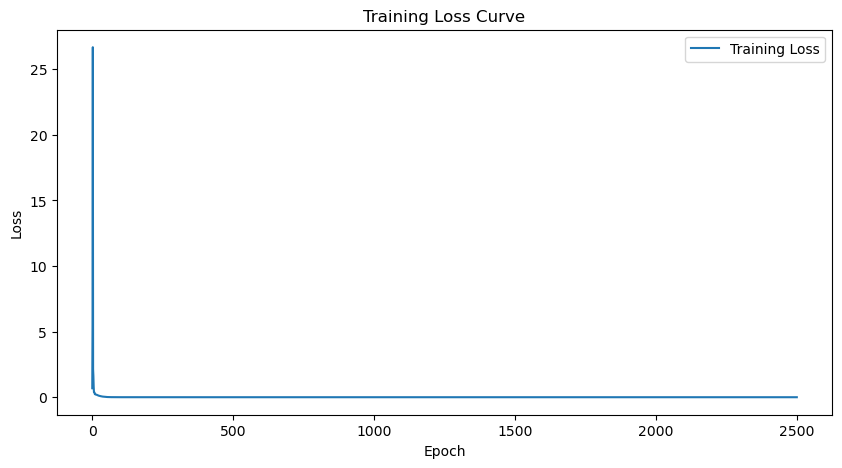

Final Model Accuracy: 92.37%
Final Model F1-score: 0.9371


In [9]:
input_dim = X_train.shape[1]
hidden_dim = 256

custom_mlp, losses, best_accuracy, best_f1 = train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim)

In [10]:
def save_checkpoint(model, optimizer, epoch, loss, filepath):
    checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, filepath)
    print(f"Checkpoint saved to '{filepath}'.")

save_checkpoint(custom_mlp, torch.optim.Adam(custom_mlp.parameters()), len(losses), losses[-1], checkpoint_file)

Checkpoint saved to '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_reference_last_token.pth'.


In [11]:
y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()
print(classification_report(y_test, y_pred_final, target_names=["infringement", "non_infringement"]))

                  precision    recall  f1-score   support

    infringement       0.95      0.86      0.90        49
non_infringement       0.91      0.97      0.94        69

        accuracy                           0.92       118
       macro avg       0.93      0.91      0.92       118
    weighted avg       0.93      0.92      0.92       118



/tmp/ipykernel_2549626/2137335780.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()
